# CNN Visualization

Team:
    -Robbie Keehan
    -Max Goldstein
    -Spencer Chang

## Why not to use Deepdream 

When analyzing a CNN visually, there are a few techniques that give valuable insights into what the CNN has learnt. One of these is by starting with a picuture of random noise or a completely empty image. Then that image is fed through the already trained network and instead of updating the layers, the layer stays the same and the input image is iteratiely updated based off of gradient ascent. One appraoch to this is to see what the network expects a specific class to look like. This gives very valuable insights into what the network expects a class to look like, which can allow a human to decide whether or not the networks ideal version of a class is what it should be. Another approach is to do something similar, but see what the output is at every layer, which is called DeepDream. DeepDream offers artist value in creating weird morphed images, but it actually can provide helpful insights

(1, 150, 150, 3)


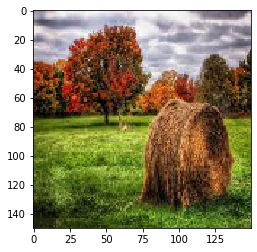

In [16]:
img_url = 'grass.jpeg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image

def load_image_as_array(url, size=(150, 150)):
#     response = requests.get(url)
    img = Image.open(img_url)
    img = img.resize(size)
    return np.array(img).astype(float)

img_tensor = load_image_as_array(img_url)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

## Loading pre-trained Model

In [2]:
from keras.applications.vgg16 import VGG16
from keras import backend as K

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Selecting a layer and channel to visualize
layer_name = 'block5_conv3'
filter_index = 0
 
# Isolate the output and loss for the given chanel
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# We take the gradient of this loss using keras backend.gradients
grads = K.gradients(loss, model.input)[0]

# Before performing gradient descent, we divide the gradient tensor by its L2 norm (square root
# of the mean of the square of values in the tensor). We add a small epsilon term to the L2 norm
# to avoid division by zero.
grads /= (K.abs(grads) + 1e-5)

# We use a keras backend function to accept a numpy tensor and return a loss and gradient for that tensor.
iterate = K.function([model.input], [loss, grads])

# # To quickly test the interface:
# import numpy as np
# loss_value, grads_value = iterate([img_tensor])




Instructions for updating:
Colocations handled automatically by placer.


In [3]:
import matplotlib.pyplot as plt

plt.matshow(activation[0, :, :, 511], cmap='viridis')
plt.show()


NameError: name 'activation' is not defined

In [17]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [20]:
def generate_pattern(layer_name, image, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    
    layer_output = model.get_layer(layer_name).output
    loss = K.sum(K.abs(layer_output))
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]


    # Normalization trick: we normalize the gradient
    grads /= K.mean(K.abs(grads)) + 1e-5

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a random image selected
    input_img_data = image

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(10):
        loss_value, grads_value = iterate([input_img_data])
        print(grads_value.shape)
        input_img_data += grads_value 
        
    img = input_img_data[0]
    return deprocess_image(img)

(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)


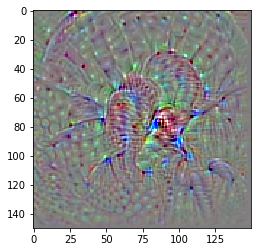

In [21]:
import matplotlib.pyplot as plt
print(img_tensor.shape)
plt.imshow(generate_pattern('block5_conv3',img_tensor))
plt.show()

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [100]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

UnboundLocalError: local variable 'pooled_grads' referenced before assignment

In [ ]:
Thought Process
0. Make Smaller X times
Deep Dream
1. Find all gradients of  A layers
2. Sum them
3. L1 normalize them
4. Perform Gradient Ascent
5. Resize Up at X
6. Merge (fuck this)
7. repeat


## Explaining model choice

## Implementing Deepdream

### Using L1 gradient normalization for gradient updates

### Adding random shifts/resizing in the process

## Testing and using deep dream process 

## Exceptional Credit: using another type of noise